In [175]:
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import pymortar
import logging 
import os
import json

from get_test_days import get_test_data
from feature_engineering import get_time_of_week, get_t_cutoff_values
from utils import get_window_of_day, get_workdays, get_closest_station, mean_absolute_percentage_error
from daily_data import get_daily_data
import get_data as gd


In [176]:
start_train = "2016-01-01T00:00:00Z"
end_train = "2018-12-21T00:00:00Z"
site = "ciee"

exclude_only_2018 = True

dr_event_dates = [
        "2017-06-16",
        "2017-06-19",
        "2017-06-20",
        "2017-06-22",
        "2017-06-23",
        "2017-07-07",
        "2017-07-27",
        "2017-07-31",
        "2017-08-01",
        "2017-08-02",
        "2017-08-28",
        "2017-08-29",
        "2017-08-31",
        "2017-09-01",
        "2017-09-02",
        "2017-06-19",
        "2017-06-20",
        "2017-07-06",
        "2017-07-07",
        "2017-07-27",
        "2017-07-31",
        "2017-08-01",
        "2017-08-28",
        "2017-08-29",
        "2017-08-31",
        "2017-09-05",
        "2017-09-12",
        "2018-06-12",
        "2018-06-13",
        "2018-07-10",
        "2018-07-16",
        "2018-07-17",
        "2018-07-19",
        "2018-07-24",
        "2018-07-25",
        "2018-07-27"
    ]

client = pymortar.Client()
cli = pymortar.Client()

dr_event_dates = [pd.to_datetime(d).date() for d in dr_event_dates]


# Get days that are similar to DR-event days to test the regression model on
test_days, train_days = get_test_data(site, dr_event_dates, start_train, end_train, cli=client)


# train baseline model on days exlcuding event days and our test set
exclude_dates = np.concatenate((test_days, dr_event_dates))

if exclude_only_2018:
    dr_exclude = [d for d in dr_event_dates if d.year == 2018]
    exclude_dates = np.concatenate((test_days, dr_exclude))

"""
Fit the regression model for a site during for the specified window
exclude_dates is a an optional set of datetime.date objects to exclude from training
cli: pymortar client
"""
start = start_train
end = end_train
interval = '15min'
agg = 'RAW'
alphas = [0.0001, .001, 0.01, 0.05, 0.1, 0.5, 1, 10]

# Get weather
weather = gd.get_weather(site, start, end, agg=agg, window=interval, cli=cli)
weather.index = weather.index.tz_localize('UTC').tz_convert('US/Pacific')
closest_station = get_closest_station(site)
if closest_station is not None:
    weather = pd.DataFrame(weather[closest_station])
else:
    weather = pd.DataFrame(weather.mean(axis=1))

# Get power
power = gd.get_power(site, start, end, agg=agg, window=interval, cli=cli) * 4
power.index = power.index.tz_localize('UTC').tz_convert('US/Pacific')

# Merge
weather_mean = pd.DataFrame(weather.mean(axis=1))
power_sum = pd.DataFrame(power.sum(axis=1))
data = power_sum.merge(weather_mean, left_index=True, right_index=True)
data.columns = ['power', 'weather']

# Get weekdays
data['date'] = data.index.date
weekdays = get_workdays(start, end)
day_filter = [d in weekdays for d in data['date']]
df = data[day_filter]

# Exclude dates
day_filter = [d not in exclude_dates for d in df.index.date]
#df = df[day_filter]

_Rendezvous: <_Rendezvous of RPC that terminated with:
	status = StatusCode.CANCELLED
	details = "Received http2 header with status: 502"
	debug_error_string = "{"created":"@1555523630.478456000","description":"Received http2 :status header with non-200 OK status","file":"src/core/ext/filters/http/client/http_client_filter.cc","file_line":121,"grpc_message":"Received http2 header with status: 502","grpc_status":1,"value":"502"}"
>

In [87]:
df.head()

,power,weather,date,time_of_year,time_of_week,time_of_day
2016-01-13 02:15:00-08:00,1920.0,53.6,2016-01-13,1044900.0,180900,8100.0
2016-01-19 08:45:00-08:00,6032.0,55.4,2016-01-19,1586700.0,117900,31500.0
2016-01-25 10:15:00-08:00,5904.0,55.4,2016-01-25,2110500.0,36900,36900.0
2016-01-26 09:15:00-08:00,7248.0,51.8,2016-01-26,2193300.0,119700,33300.0
2016-01-29 12:30:00-08:00,7072.0,60.8,2016-01-29,2464200.0,390600,45000.0


In [41]:
df = df.dropna()

In [42]:
df = df[df['power'] != 0]

In [43]:
def time_of_year(ts):
    delta = ts - pd.to_datetime(ts.year.astype(str)).tz_localize(ts.tz)
    return delta.total_seconds()

In [44]:
def time_of_week(ts):
    return 60*60*24 * ts.dayofweek + 60*60 * ts.hour + 60*ts.minute

In [45]:
def time_of_day(ts):
    delta = ts - pd.to_datetime(ts.date).tz_localize(ts.tz)
    return delta.total_seconds()

In [46]:
df['time_of_year'] = time_of_year(df.index)

In [47]:
df['time_of_week'] = time_of_week(df.index)

In [48]:
df['time_of_day'] = time_of_day(df.index)

In [49]:
df.head()

,power,weather,date,time_of_year,time_of_week,time_of_day
2016-01-13 02:15:00-08:00,1920.0,53.6,2016-01-13,1044900.0,180900,8100.0
2016-01-19 08:45:00-08:00,6032.0,55.4,2016-01-19,1586700.0,117900,31500.0
2016-01-25 10:15:00-08:00,5904.0,55.4,2016-01-25,2110500.0,36900,36900.0
2016-01-26 09:15:00-08:00,7248.0,51.8,2016-01-26,2193300.0,119700,33300.0
2016-01-29 12:30:00-08:00,7072.0,60.8,2016-01-29,2464200.0,390600,45000.0


In [60]:
X, y = df.drop(columns=['power', 'date']), df['power']

In [51]:
exclude = np.array([d in exclude_dates for d in df.index.date]) 
test_filter = np.array([d in test_days for d in df.index.date])

In [52]:
train = df[~exclude]

In [53]:
test = df[test_filter]

In [54]:
df.shape

(43457, 6)

In [55]:
test.shape

(2366, 6)

In [56]:
over_75_train = train[train['weather'] >= 75.0]
over_75_test = test[test['weather'] >= 75.0]

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


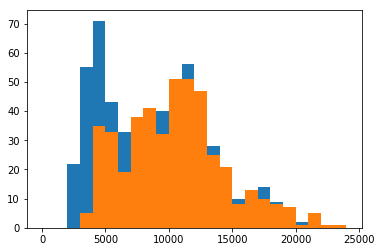

In [57]:
plt.hist(over_75_train['power'], bins = range(0, 25000, 1000));
plt.hist(over_75_test['power'], bins = range(0, 25000, 1000));

In [58]:
bad_data = over_75_train[over_75_train['power'] < 5000]

In [59]:
bad_data.to_csv('ciee_bad_data_raw.csv')

In [318]:
weights = X['weather'] > 75

In [322]:
weights = weights.astype(int) + 1

In [61]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=8)
new = poly.fit_transform(X)

In [62]:
test_filter = np.array([d in test_days for d in df.index.date])

In [63]:
exclude = np.array([d in exclude_dates for d in df.index.date]) 

In [64]:
X_train, X_test, y_train, y_test= new[~exclude], new[test_filter], y[~exclude], y[test_filter]

In [66]:
from sklearn.linear_model import RidgeCV


In [76]:
model = RidgeCV(alphas=[0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10], normalize=True)

In [77]:
model.fit(X_train, y_train)

RidgeCV(alphas=array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01]),
    cv=None, fit_intercept=True, gcv_mode=None, normalize=True,
    scoring=None, store_cv_values=False)

In [78]:
model.alpha_

1e-05

In [79]:
y_pred = model.predict(X_test)

In [80]:
mean_squared_error(y_pred, y_test)

6410188.266303776

In [81]:
np.sqrt(mean_squared_error(y_pred, y_test))

2531.8349603210268

In [82]:
import matplotlib.pyplot as plt

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


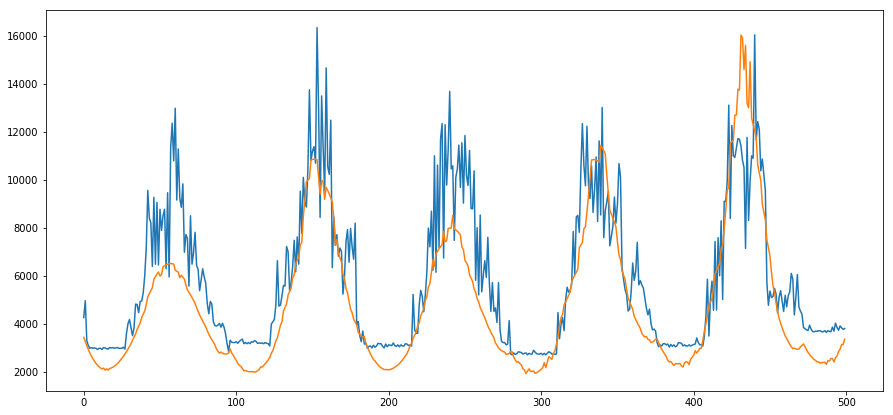

In [83]:
plt.figure(figsize=(15, 7))
plt.plot(range(500), y_test[:500])
plt.plot(range(500), y_pred[:500])

### Splitting Occupied vs. Unoccupied

In [90]:
start_hour = 9
end_hour = 18

In [93]:
occupied_mask = (df.index.hour >= start_hour) & (df.index.hour <= end_hour)
occupied_df = df[occupied_mask]
unoccupied_df = df[~occupied_mask]

In [102]:
# Occupied

X, y = occupied_df.drop(columns=['power', 'date']), occupied_df['power']
poly = PolynomialFeatures(degree=8)
new = poly.fit_transform(X)
exclude = np.array([d in exclude_dates for d in occupied_df.index.date]) 
test_filter = np.array([d in test_days for d in occupied_df.index.date])
X_train, X_test, y_train, y_test= new[~exclude], new[test_filter], y[~exclude], y[test_filter]
model.fit(X_train, y_train)
model.alpha_

1e-05

In [103]:
y_pred = model.predict(X_test)

In [104]:
mean_squared_error(y_pred, y_test)

13144307.660916524

In [105]:
np.sqrt(mean_squared_error(y_pred, y_test))

3625.507917646371

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


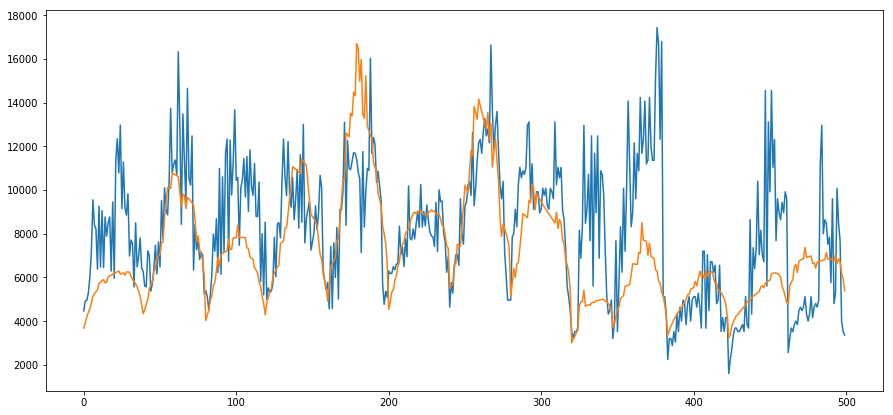

In [106]:
plt.figure(figsize=(15, 7))
plt.plot(range(500), y_test[:500])
plt.plot(range(500), y_pred[:500])

In [107]:
# Unoccupied
X, y = unoccupied_df.drop(columns=['power', 'date']), unoccupied_df['power']
poly = PolynomialFeatures(degree=8)
new = poly.fit_transform(X)
exclude = np.array([d in exclude_dates for d in unoccupied_df.index.date]) 
test_filter = np.array([d in test_days for d in unoccupied_df.index.date])
X_train, X_test, y_train, y_test= new[~exclude], new[test_filter], y[~exclude], y[test_filter]
model.fit(X_train, y_train)
model.alpha_

1e-05

In [108]:
y_pred = model.predict(X_test)

In [109]:
mean_squared_error(y_pred, y_test)

1760309.4041530557

In [110]:
np.sqrt(mean_squared_error(y_pred, y_test))

1326.7665220953745

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


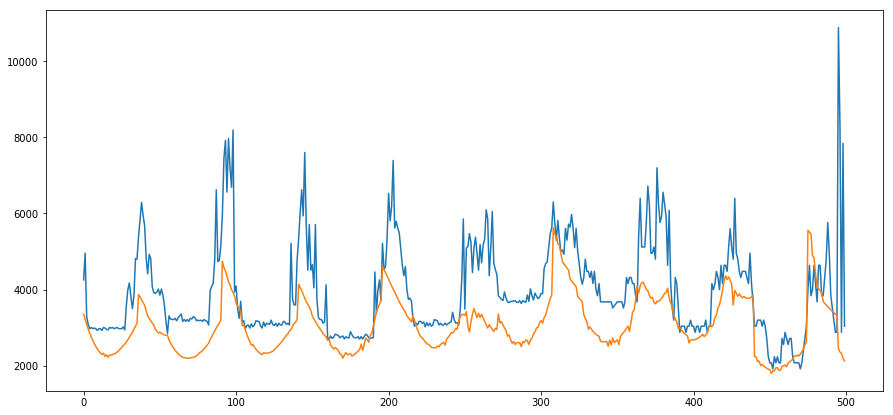

In [111]:
plt.figure(figsize=(15, 7))
plt.plot(range(500), y_test[:500])
plt.plot(range(500), y_pred[:500])

### Try original model with Occupied / Unoccupied

In [161]:
# Get time of weed
df['time_of_week'] = [get_time_of_week(t) for t in df.index]
indicators = pd.get_dummies(df['time_of_week'])
df = df.merge(indicators, left_index=True, right_index=True)
df = df.drop(labels=['time_of_week'], axis=1)

In [162]:
# Get temperature cutoffs
cutoffs = [40, 55, 70, 80, 90]
arr = df['weather'].apply(lambda t: get_t_cutoff_values(t, cutoffs)).values
a = np.array(arr.tolist())
t_features = pd.DataFrame(a)
t_features.columns = ['temp_cutoff_' + str(i) for i in cutoffs] + ['max_cutoff']
t_features.index = df.index
df = df.merge(t_features, left_index=True, right_index=True)

In [163]:
occupied_mask = (df.index.hour >= start_hour) & (df.index.hour <= end_hour)
occupied_df = df[occupied_mask]
unoccupied_df = df[~occupied_mask]

In [164]:
X, y = df.drop(['power', 'date', 'weather', 'time_of_year', 'time_of_day'], axis=1), df['power']

In [165]:
# occupied
X, y = occupied_df.drop(columns=['power', 'date', 'weather', 'time_of_year', 'time_of_day']), occupied_df['power']
exclude = np.array([d in exclude_dates for d in occupied_df.index.date]) 
test_filter = np.array([d in test_days for d in occupied_df.index.date])
X_train, X_test, y_train, y_test= X[~exclude], X[test_filter], y[~exclude], y[test_filter]
model = RidgeCV(normalize=True, alphas=alphas)
model.fit(X_train, y_train)
model.alpha_

0.05

In [125]:
y_pred = model.predict(X_test)
mean_squared_error(y_pred, y_test)

13881769.625270404

In [126]:
np.sqrt(mean_squared_error(y_pred, y_test))

3725.8246906249365

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


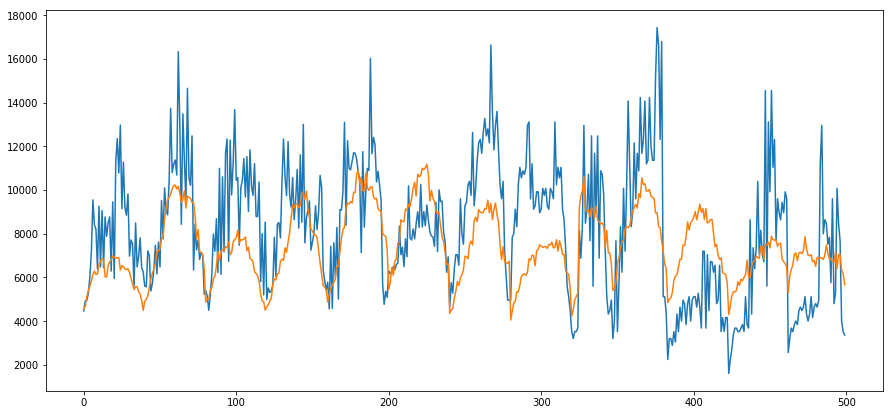

In [127]:
plt.figure(figsize=(15, 7))
plt.plot(range(500), y_test[:500])
plt.plot(range(500), y_pred[:500])

In [131]:
# occupied
X, y = unoccupied_df.drop(columns=['power', 'date', 'time_of_year', 'time_of_day', 'temp_cutoff_40', 'temp_cutoff_50', 'temp_cutoff_60', 'temp_cutoff_70', 'temp_cutoff_80', 'max_cutoff']), unoccupied_df['power']
exclude = np.array([d in exclude_dates for d in unoccupied_df.index.date]) 
test_filter = np.array([d in test_days for d in unoccupied_df.index.date])
X_train, X_test, y_train, y_test= X[~exclude], X[test_filter], y[~exclude], y[test_filter]
model = RidgeCV(normalize=True, alphas=alphas)
model.fit(X_train, y_train)
model.alpha_

0.05

In [132]:
y_pred = model.predict(X_test)
mean_squared_error(y_pred, y_test)

1684390.0094122384

In [133]:
np.sqrt(mean_squared_error(y_pred, y_test))

1297.8405177109546

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


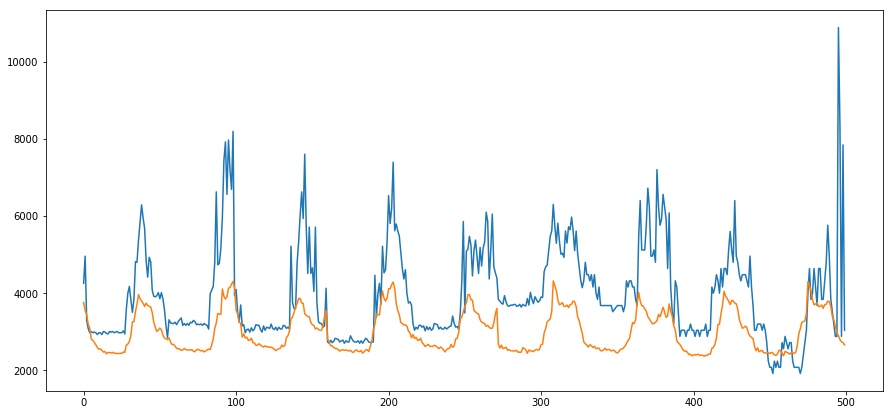

In [134]:
plt.figure(figsize=(15, 7))
plt.plot(range(500), y_test[:500])
plt.plot(range(500), y_pred[:500])

### Finding better intervals

In [139]:
simple = df[['power', 'weather']]
simple.head()

,power,weather
2016-01-13 02:15:00-08:00,1920.0,53.6
2016-01-19 08:45:00-08:00,6032.0,55.4
2016-01-25 10:15:00-08:00,5904.0,55.4
2016-01-26 09:15:00-08:00,7248.0,51.8
2016-01-29 12:30:00-08:00,7072.0,60.8


In [155]:
simple['floor'] = np.floor_divide(df['weather'], 5)

/Users/jleyden/anaconda3/envs/mortar/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [156]:
median_powers = simple.groupby('floor').median()['power']

In [157]:
mean_powers = simple.groupby('floor').mean()['power']

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


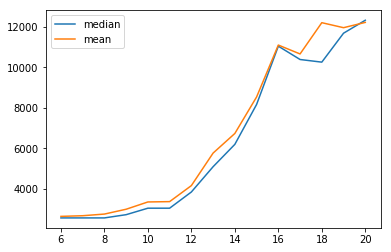

In [160]:
plt.plot(median_powers.index, median_powers, label='median')
plt.plot(mean_powers.index, mean_powers, label='mean')
plt.legend()